## Explainability in Graph Neural Networks

Adapted from the [original notebook](https://colab.research.google.com/drive/1nV44NrNqcXC2thU6-zzxnJPnIalo870m) from [Simone Scardapane](https://www.sscardapane.it/).

Libraries:

<img src="imgs/libraries.png" width=400px />

In [1]:
import os, torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# PyTorch imports
from torch.nn import functional as F

# PyTorch-related imports
import torch_geometric as pyg
import torch_scatter, torch_sparse

# PyG explainability
from torch_geometric.explain import Explainer, GNNExplainer

import pytorch_lightning as ptlight
from torchmetrics.functional import accuracy

# Other imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

# Finally, Captum
from captum.attr import IntegratedGradients
from captum.influence import TracInCP, TracInCPFast

1.13.0


## 1. Dataset exploration

We consider the [MUTAG](https://paperswithcode.com/dataset/mutag) dataset, a collection of nitroaromatic compounds. 
The goal is to predict their mutagenicity on Salmonella typhimurium

This is a toy version, so we do not care too much about the final performance. 

This part is re-adapted from the [PyG intro tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-handling-of-graphs).

Download the data

In [2]:
mutag = pyg.datasets.TUDataset(root='.', name='MUTAG')

Print some statistics about the dataset

In [3]:
print(f"graph samples: {len(mutag)}")
print(f"classes: {mutag.num_classes}") # Binary (graph-level) classification
print(f"node features: {mutag.num_features}") # One-hot encoding for each node type (atom)
print(f"edge features: {mutag.num_edge_features}") # One-hot encoding for the bond type (we will ignore this)

graph samples: 188
classes: 2
node features: 7
edge features: 4


Each graph in the dataset is represented as an instance of the generic [Data object](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data)

In [4]:
mutag_0 = mutag[0]
print(type(mutag_0))

<class 'torch_geometric.data.data.Data'>


In [5]:
# x contains the node features
mutag_0.x.shape

torch.Size([17, 7])

In [6]:
# y contains the corresponding class
mutag_0.y

tensor([1])

The Edges are stored in a COO format, with a 2xE list (``edge_index[:, i]`` are the source and target nodes of the $i$-th edge)

In [7]:
mutag_0.edge_index.shape

torch.Size([2, 38])

In [8]:
# We print the first four edges in the list
mutag_0.edge_index[:, 0:4]

tensor([[0, 0, 1, 1],
        [1, 5, 0, 2]])

Inside ``pyg.utils`` there are a number of useful tools.

E.g., we can check that the graph is undirected (the adjacency matrix is symmetric))

In [9]:
pyg.utils.is_undirected(mutag_0.edge_index)

True

We define a simple function for plotting the graph using the tools from networkx

In [12]:
colors = list(mcolors.TABLEAU_COLORS)
def draw_graph(g: pyg.data.Data):
  # Get a different color for each atom type
  node_color = [colors[i.item()] for i in g.x.argmax(dim=1)]
  # Convert to networkx
  g = pyg.utils.to_networkx(g, to_undirected=True)
  # Draw on screen
  pos = nx.planar_layout(g)
  pos = nx.spring_layout(g, pos=pos)
  nx.draw_networkx(g, node_color=node_color)

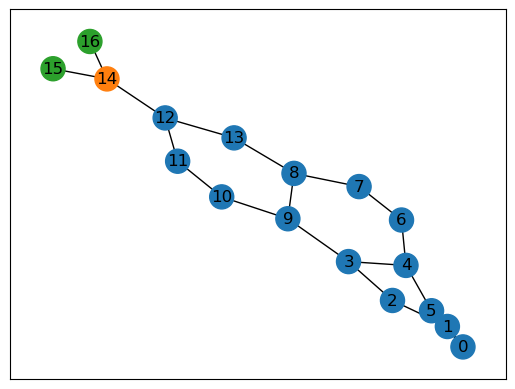

In [13]:
draw_graph(mutag_0)

In [17]:
from torch_geometric.utils import to_networkx

def draw_molecule(g, edge_mask=None, draw_edge_labels=False, ax=None):
    g = g.copy().to_undirected()
    node_labels = {}
    for u, data in g.nodes(data=True):
        node_labels[u] = data['name']
    pos = nx.planar_layout(g)
    pos = nx.spring_layout(g, pos=pos)
    if edge_mask is None:
        edge_color = 'black'
        widths = None
    else:
        edge_color = [edge_mask[(u, v)] for u, v in g.edges()]
        widths = [x * 10 for x in edge_color]
    nx.draw_networkx(g, pos=pos, labels=node_labels, width=widths,
            edge_color=edge_color, edge_cmap=plt.cm.Blues,
            node_color='azure')

    if draw_edge_labels and edge_mask is not None:
        edge_labels = {k: ('%.2f' % v) for k, v in edge_mask.items()}
        nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels,
                                    font_color='red', ax=ax)

    if ax is None:
      plt.show()


def to_molecule(data: pyg.data.Data):
    ATOM_MAP = ['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca']
    g = to_networkx(data, node_attrs=['x'])
    for u, data in g.nodes(data=True):
        data['name'] = ATOM_MAP[data['x'].index(1.0)]
        del data['x']
    return g

We can also use a more advanced drawing script (taken from [here](https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing)) that also shows the atom type

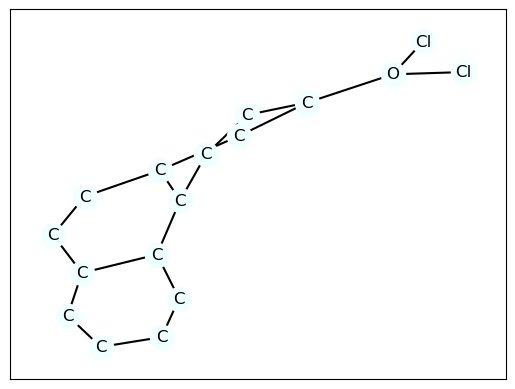

In [18]:
draw_molecule(to_molecule(mutag_0))

## 2. Transformations
Transformations are a quick way to include standard preprocessing when loading the graphs (e.g., automatically computing edge from the nodes positions). 

See the full list of available transformations [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html).

As an experiment, we load the graph with a sparse adjacency format instead of the COO list

In [21]:
mutag_adj = pyg.datasets.TUDataset(root='.', name='MUTAG',
                                   transform=pyg.transforms.ToSparseTensor())

We now have the adjacency matrix available as an additional propertyty)

In [22]:
mutag_adj[0].adj_t # This gives us useful information (size, nnz, density)

SparseTensor(row=tensor([ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,
                            8,  8,  8,  9,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14,
                           15, 16]),
             col=tensor([ 1,  5,  0,  2,  1,  3,  2,  4,  9,  3,  5,  6,  0,  4,  4,  7,  6,  8,
                            7,  9, 13,  3,  8, 10,  9, 11, 10, 12, 11, 13, 14,  8, 12, 12, 15, 16,
                           14, 14]),
             size=(17, 17), nnz=38, density=13.15%)

The sparse matrix format supports [several useful methods](https://github.com/rusty1s/pytorch_sparse).

For example, we can propagate the features on the graph (cornerstone of graph-based methods) efficiently with a sparse-dense matrix multiplication

In [23]:
print(torch_sparse.matmul(mutag_adj[0].adj_t, mutag_adj[0].x).shape)

torch.Size([17, 7])


## 3. Data loaders

Data loaders are a nice utility to automatically build mini-batches from the dataset.

A batch can either be a set of graphs, or subgraphs extracted from a single graph.

First, we split the original dataset into a training and test spart with a stratified split on the class

In [25]:
train_idx, test_idx = train_test_split(range(len(mutag)), stratify=[m.y[0].item() for m in mutag], test_size=0.25)

Then, we build the two loaders

In [28]:
train_loader = pyg.loader.DataLoader(mutag[train_idx], batch_size=32, shuffle=True)
test_loader = pyg.loader.DataLoader(mutag[test_idx], batch_size=32)

Let us inspect the first batch of data

In [29]:
batch = next(iter(train_loader))

The batch is built by considering all the subgraphs as a single giant graph with unconnected components

<img src="imgs/disjoint.PNG" width=400px />

In [30]:
print(batch.x.shape) # All the nodes of the 32 graphs are put together
print(batch.y.shape) # A single label for each graph
print(batch.edge_index.shape) # Edge list of all 32 graphs

torch.Size([578, 7])
torch.Size([32])
torch.Size([2, 1288])


There is an additional property in ``batch`` that links each node to its corresponding graph index

In [32]:
print(batch.batch.shape)
print(batch.batch[0:30]) # print the first 30 elements

torch.Size([578])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1])


We can perform graph-level operations with ``torch_scatter`` (more details [here](https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html))

<img src="imgs/scatter.PNG" width=400px />

In [33]:
# Sum all the nodes in the same graph
print(torch_scatter.scatter_sum(batch.x, batch.batch, dim=0).shape)

torch.Size([32, 7])


In [34]:
# Average all the nodes in the same graph
print(torch_scatter.scatter_mean(batch.x, batch.batch, dim=0).shape)

torch.Size([32, 7])


In [35]:
# Alternatively, PyG has this implemented as a functional layer
pyg.nn.global_mean_pool(batch.x, batch.batch).shape

torch.Size([32, 7])